<a href="https://colab.research.google.com/github/kennethjiang/3DPrintSaviour/blob/master/Anomaly_Detection_Nezih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

from glob import glob
glob("/content/drive/MyDrive/timelapses/*", recursive = False)

Mounted at /content/drive


['/content/drive/MyDrive/timelapses/DASH_480.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-3.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-4.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-5.mp4',
 '/content/drive/MyDrive/timelapses/DASH_480-2.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-7.mp4',
 '/content/drive/MyDrive/timelapses/multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743.mp4',
 '/content/drive/MyDrive/timelapses/Merged_0.15mm_PLA_MK3SMMU2S_1h8m_20220324025925.mp4',
 '/content/drive/MyDrive/timelapses/Lever_0.15mm_PLA_MK3SMMU2S_5h26m_20220501013518.mp4',
 '/content/drive/MyDrive/timelapses/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220502124240.mp4',
 '/content/drive/MyDrive/timelapses/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220503163150.mp4',
 '/content/drive/MyDrive/timelapses/newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220509072520.mp4',
 '/content/drive/MyDrive/timelapses/Pix

In [2]:
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
%pip install sewar==0.4.5

import cv2
import numpy as np
from numpy import linalg as LA
from datetime import datetime
import matplotlib.pyplot as plt
# from sewar.full_ref import mse, rmse, psnr, uqi, ergas, scc, rase, sam, msssim, vifp
from sewar.full_ref import mse, rmse
from skimage.metrics import structural_similarity as ssim
import os
from sklearn.cluster import DBSCAN
import scipy
import scipy.signal
from numpy import linalg as LA
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import logging
import math
from shapely.geometry import Polygon, Point
from skimage.metrics import structural_similarity as ssim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=6e1ed3e61c68a4b588cf8af0ed3b5f3338454d578ef7f6ef91622d97a4d986ed
  Stored in directory: /root/.cache/pip/wheels/d5/46/c1/7d4cdb3e32c09f3186ed699b12ac8aef0152932ab72f8fc9a5
Successfully built sewar


In [4]:
def read_next_frame(cap):
  """
  Read the next frame from the video, and resize MAX_WIDTH if necessary.
  """
  resize = 0
  width = int(cap.get(3))
  height = int(cap.get(4))
  if width>MAX_WIDTH:
    dividor = MAX_WIDTH/width
    height = int(dividor*height)
    width = MAX_WIDTH
    resize = 1

  _, frame = cap.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  if resize:
    return cv2.resize(frame, (width,height), interpolation= cv2.INTER_LINEAR)
  else:
    return frame


In [5]:
def cropping_area(frame):

  crop_ratio = 0.18

  (height, width) = frame.shape
  # Using the crop_ratio, the outer part of the video is determined:
  yRange = range(int(height*crop_ratio),int(height*(1-crop_ratio)))
  xRange = range(int(width*crop_ratio),int(width*(1-crop_ratio)))
  yMin = yRange[0]
  yMax = yRange[-1]
  xMin = xRange[0]
  xMax = xRange[-1]

  return (yRange, xRange, yMin, yMax, xMin, xMax)


def crop_frame(frame):
  yRange, xRange, yMin, yMax, xMin, xMax = cropping_area(frame)
  return frame[yMin:yMax,xMin:xMax]

In [6]:
def extractSIFT(frame):
    """
    Extracts SIFT features from the frame
    """
    # Gaussian blur kernel size:
    blur_kernel = 5

    # Get frame dimensions:
    width = frame.shape[1]
    height = frame.shape[0]

    # extract RootSIFT descriptors
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()

    # Gaussian blur:
    frame = cv2.GaussianBlur(frame,(blur_kernel,blur_kernel),0)

    # Copy of the frame:
    # frameOrg = frame.copy()

    # Another copy of the frame (for drawing clusters):
    # imageToDrawClusters = frame.copy()

    # Extract SIFT features:
    return sift.detectAndCompute(frame.astype(np.uint8),None)

In [7]:
def getFeaturesMask(frame, kps, savePNG = False):
    """
    Returns a mask created by these features.
    But how? What kind of role does DBSCAN plays? Nezih Topaloglu please elaborate!
    NT: The only aim of clustering is to remove outliers.
    """
    

    # DBSCAN parameters:
    eps = 15
    min_samples = 3

    number_of_dilation_iterations = 12

    # Definition of arrays:
    siftArray = []
    maskXarray = []
    maskYarray = []

    # The x and y coordinates of keypoints are stored in separate arrays:
    for i in range(len(kps)):
        maskX = int(kps[i].pt[0])
        maskY = int(kps[i].pt[1])
        maskXarray.append(maskX)
        maskYarray.append(maskY)



    # Combine the arrays and convert them to numpy arrays:
    duo = tuple((maskYarray, maskXarray))
    mydata = np.array(duo).T

    # Clustering:
    try:
        # DBSCAN model with parameters
        model = DBSCAN(eps=eps, min_samples=min_samples).fit(mydata)
    except ValueError:
        print("not enough data for clustering.")
        return False,None,None


    labels = model.labels_

    # Unique labels:
    unique_labels = set(labels)



    # Draw clusters (for debugging):
    # unique_labels_list = list(unique_labels)
    # max_label = max(unique_labels) + 1
    # for i in range(labels.shape[0]):
    #     if labels[i] == -1:
    #         radius = 8
    #     else:
    #         radius = 4
    #         #print('non noise label :',labels[i])
    #         #colorTrio = tuple(colors[labels[i]]*255)
    #     colorSingle = 255 * (labels[i] + 1) / max_label
    #     colorTrio = (colorSingle, colorSingle, colorSingle)
    #         #print('colurTrio ',colorTrio)
    #     cv2.circle(imageToDrawClusters, (mydata[i, 1], mydata[i, 0]),
    #             radius=radius,
    #             color=colorTrio,
    #             thickness=-1)
    # plt.imshow(imageToDrawClusters)
    # plt.show()


    # Outliers are removed from the data:
    myDataWithoutOutliers = mydata[np.where(labels != -1)]


    # Draw clusters without outliers (for debugging):
    # frameOrgWithCleanedData = frameOrg.copy()
    # for i in range(len(myDataWithoutOutliers)):
    #     maskY = myDataWithoutOutliers[i][0]
    #     maskX = myDataWithoutOutliers[i][1]
    #     cv2.circle(frameOrgWithCleanedData, (maskX, maskY),
    #     radius=5,
    #     color=(255,255,255),
    #     thickness=-1)
    # plt.imshow(frameOrgWithCleanedData)
    # plt.show()

    # Create a mask from the data:
    mask1 = np.zeros_like(frame)
    mask1[tuple((myDataWithoutOutliers[:,0],myDataWithoutOutliers[:,1]))] = 255

    # The kernel for dilation:
    kernel = np.ones((5,5), np.uint8)

    # Dilate the image to combine the non-contiguous 1s:
    output_mask = cv2.dilate(mask1, kernel, iterations=number_of_dilation_iterations)


    return True,output_mask

In [8]:
def calc2FrameDiffAbs(frameDuo):

    frame1 = frameDuo[0].astype(np.float32)
    frame1 /= 255
    # print(frame1.shape)

    frame2 = frameDuo[1].astype(np.float32)
    frame2 /= 255

    frame2 -= frame1
    # print(frame2.shape)

    final = np.zeros_like(frame2)
    # cv2.normalize(np.abs(frame2), final, 0, 255, cv2.NORM_MINMAX)
    # print(final.shape)
    # print(np.mean(final))
    # return final.astype(np.uint8)

    return (np.abs(frame2)*255).astype(np.uint8)

In [9]:
def get_layer1_and_layer0_tuple(cap, initial_layer_frame):
    """
    Return: (layer1_frame, layer0_frame)
    """

    # If initial_layer_frame is not 0, the video is read until the initial_layer_frame:
    if initial_layer_frame:

        frameNo = 2
        if initial_layer_frame == 1:
            frame0 = firstFrame.copy()
            frame1 = read_next_frame(cap)
            frameNo+=1

        else:
            while frameNo <= initial_layer_frame:
                ## After this while loop ends, frame0 is the frame at "initial_layer_frame-1"
                frame0 = read_next_frame(cap)
                frameNo+=1
            ## frame1 is the frame at "initial_layer_frame"
            frame1 = read_next_frame(cap)
            frameNo+=1

        # frame0Cropped is the frame before the initial layer frame:
        # frame0Cropped = frame0[yMin:yMax,xMin:xMax]
        # frame1Cropped is the initial layer frame:
        # frame1Cropped = frame1[yMin:yMax,xMin:xMax]
        # frame1 = frame1[:,xRange]

        return (frame1, frame0, frameNo)
    else:
        # If there is no initial layer frame, thw weight matrix is unchanged (it's a matrix of 1s)
        frame1 = firstFrame.copy()
        # frame1 = frame1[yRange,:]
        # frame1 = frame1[:,xRange]
        # frame1Cropped = frame1[yMin:yMax,xMin:xMax]
        return (frame1, None, frameNo)



In [36]:
def adjust_weight_matrix_using_conv_hull(layer1_frame, layer0_frame, debug=True):
    """
    This is to calculate conv hull using the intital frame, and use that conv hull to adjust the weight matrix.
    !!! Not working yet !!!
    """

    frame1 = layer1_frame
    frame1Cropped = crop_frame(frame1)
    frame0 = layer0_frame
    frame0Cropped = crop_frame(frame0)

    #   SIFT mask is created using the first frame:
    
    ## My best guess of this part is to use SIFT to extract feature, and create a mask in the feature-rich areas.
    ## However, this is based on 2 assumptions that beg verification:
    ##   1. The print bed is clean. Many users' print beds are really messy
    ##   2. The "background area" is feature rich. This may not be the case
    # NT: The purpose of this mask was to improve the convHull algorithm. It is not a must to use this mask.

    ## Also why is this based on the cropped area, instead of the whole picture? Aren't the fringe areas a lot more
    ## likely to be the background, instead of the object? Nezih Topaloglu

    croppedFirstFrame = crop_frame(firstFrame)
    kps, descs = extractSIFT(croppedFirstFrame)

    if debug:
      plt.imshow(cv2.drawKeypoints(croppedFirstFrame,kps,croppedFirstFrame),)
      plt.title('Cropped first frame with SIFT overlay')
      plt.colorbar()
      plt.show()

    ret_sift,sift_mask = getFeaturesMask(croppedFirstFrame, kps)

    if debug:
      plt.imshow(croppedFirstFrame * (sift_mask/255), cmap='gray')
      plt.title('Cropped first frame masked by the feature clusers')
      plt.colorbar()
      plt.show()

    # initial_layer_diff_frame is the difference between the two frames:
    initial_layer_diff_frame = calc2FrameDiffAbs(np.stack((frame0Cropped,frame1Cropped)))

    if debug:
      plt.imshow(initial_layer_diff_frame, cmap='gray')
      plt.title('Cropped image diff between layer 0 (empty bed) and layer 1 (initial layer)')
      plt.colorbar()
      plt.show()

    # If SIFT mask gives an output, the regions with these features are removed from the initial_layer_diff_frame:
    if ret_sift:
        sift_mask = np.bitwise_not(sift_mask)/255

        initial_layer_diff_frame = np.multiply(initial_layer_diff_frame,sift_mask).astype(np.uint8)

    if debug:
      plt.imshow(initial_layer_diff_frame, cmap='gray')
      plt.title('Cropped, masked image diff between layer 0 (empty bed) and layer 1 (initial layer)')
      plt.colorbar()
      plt.show()

    # The weight matrix, which is the result of the convex hull calculation, is found:
    print("Calculating convex hull, at frame: ",frameNo)
    ret_convex_hull,weight_matrix,weight_matrix_binary,_,_,_ = calculateConvexHull(initial_layer_diff_frame,url[7:-4],provideURL = False)

def get_frame_duo(new_frame, frameDuo, frameEdgeDuo, weight_matrix):
  applyBlur = True
  frame_blur_kernel_size = 3
  frameEdge_blur_kernel_size = 9
  frameEdge_median_kernel_size = 3
  cannyLower = 25
  cannyUpper = 40

  cropped_frame = crop_frame(new_frame)
  # Apply Gaussian Blur
  if applyBlur == True:
      frame = cv2.GaussianBlur(cropped_frame,(frame_blur_kernel_size,frame_blur_kernel_size),0)

  if frameDuo is None:
    frameDuo = np.zeros((2,) + cropped_frame.shape)

  # Rolling frameDuo and updating its last element:
  frameDuo = np.roll(frameDuo, -1, axis=0)
  frameDuo[1] = np.multiply(frame.copy().astype(np.uint8), weight_matrix)
  # frameDuo[0] = frameDuo[0].astype(np.uint8)

  # For edge detection

  if frameEdgeDuo is None:
    frameEdgeDuo = np.zeros((2,) + cropped_frame.shape)

  frameForEdge = cropped_frame.copy()

  # Apply Gaussian Blur to frameEdge:
  if applyBlur == True:
    frameForEdge = cv2.GaussianBlur(frameForEdge,(frameEdge_blur_kernel_size,frameEdge_blur_kernel_size),0)
    frameForEdge = cv2.medianBlur(frameForEdge.astype(np.uint8),frameEdge_median_kernel_size)

  cannyOutput = cv2.Canny(frameForEdge.astype(np.uint8), cannyLower, cannyUpper)

  #Rolling and updating the frameEdgeDuo:
  frameEdgeDuo = np.roll(frameEdgeDuo, -1, axis=0)
  frameEdgeDuo[1] = np.multiply(cannyOutput.copy().astype(np.uint8), weight_matrix)

  return (frameDuo, frameEdgeDuo)

def search_min_edge_diff_with_shifts(frameEdgeDuo):
  warp_try_edge = True
  edge_warp_range = 2

  (heightCropped, widthCropped) = frameEdgeDuo[0].shape

  # Eliminating possible false positives due to small camera movements:
  if warp_try_edge == True:
      warped_array = np.zeros(((edge_warp_range*2+1)**2,heightCropped,widthCropped), dtype = np.float64)
      warped_array_idx = 0
      for idx_x,i in enumerate(range(-edge_warp_range,edge_warp_range+1)):
          for idx_y,j in enumerate(range(-edge_warp_range,edge_warp_range+1)):
              M = np.float32([[1,0,i],[0,1,j]])
              warped = cv2.warpAffine(frameEdgeDuo[1],M,(widthCropped,heightCropped))
              warped_array[warped_array_idx] = (warped.astype(np.float64) - frameEdgeDuo[0].astype(np.float64))**2
              warped_array_idx += 1

      # warpedMin = np.sqrt(np.mean(np.amin(warped_array, axis = 0)))
      warpedMin = np.mean(np.amin(warped_array, axis = 0))

  else:

      warpedMin = rmse(frameEdgeDuo[1],frameEdgeDuo[0])

  return warpedMin/(heightCropped*widthCropped)


def search_min_frame_diff_with_shifts(frameDuo):

  RANGE = 3
  loss = rmse

  (heightCropped, widthCropped) = frameDuo[0].shape

  frameDuo[0][:RANGE] = 0
  frameDuo[0][:,:RANGE] = 0
  frameDuo[0][-RANGE:] = 0
  frameDuo[0][:,-RANGE:] = 0

  frameDuo[1][:RANGE] = 0
  frameDuo[1][:,:RANGE] = 0
  frameDuo[1][-RANGE:] = 0
  frameDuo[1][:,-RANGE:] = 0


  pento = np.zeros((2*RANGE+1,2*RANGE+1))

  for idx_x,i in enumerate(range(-RANGE,RANGE+1)):
      for idx_y,j in enumerate(range(-RANGE,RANGE+1)):
          M = np.float32([[1,0,i],[0,1,j]])
          warped = cv2.warpAffine(frameDuo[1],M,(widthCropped,heightCropped))
          warped[:RANGE] = 0
          warped[:,:RANGE] = 0
          warped[-RANGE:] = 0
          warped[:,-RANGE:] = 0
          pento[idx_x,idx_y] = loss(frameDuo[0],warped)/(heightCropped*widthCropped)
  # print(frameNo,np.min(pento),np.max(pento))
  lossData = np.amin(pento)

  return lossData

def calc_a_bunch_of_loss_stuff(frame_diff_arr, edge_mean_arr, edge_diff_arr):
  window_size = 8
  loss_limit = 2e-5
  edge_loss_limit = 1e-5
  edge_sigma_limit = 3.65
  check2_offset = 0.9
  sigma_limit = 3

  window = window_size
  coeff = math.sqrt(math.sqrt(window/window_size))


  # Dataframe columns are the equivalents of the variables of the same name in the original code
  lossDf = pd.DataFrame({"lossArr": frame_diff_arr, "meanEdgeArr": edge_mean_arr, "edgeLossArr": edge_diff_arr})

  lossDf['movAvg'] = lossDf['lossArr'].rolling(window=window_size, center=False).mean()
  lossDf['movStd'] = lossDf['lossArr'].rolling(window=window_size, center=False).std()
  lossDf['sigma'] = np.abs(lossDf['lossArr'] - lossDf['movAvg']) / lossDf['movStd'] + 1e-7

  lossDf['movAvgEdge'] = lossDf['edgeLossArr'].rolling(window=window_size, center=False).mean()
  lossDf['movStdEdge'] = lossDf['edgeLossArr'].rolling(window=window_size, center=False).std()
  lossDf['sigmaEdge'] = np.abs(lossDf['edgeLossArr'] - lossDf['movAvgEdge']) / lossDf['movStdEdge'] + 1e-7

  lossDf['movAvgEdgeMean'] = lossDf['meanEdgeArr'].rolling(window=window_size, center=False).mean()
  lossDf['movStdEdgeMean'] = lossDf['meanEdgeArr'].rolling(window=window_size, center=False).std()
  lossDf['sigmaEdgeMean'] = np.abs(lossDf['meanEdgeArr'] - lossDf['movAvgEdgeMean']) / lossDf['movStdEdgeMean'] + 1e-7

  lossDf['check1'] = (lossDf['sigmaEdge'] > edge_sigma_limit*coeff) & (lossDf['lossArr'] > loss_limit) & (lossDf['edgeLossArr'] > edge_loss_limit)
  lossDf['check2'] = (lossDf['sigmaEdge'] + lossDf['sigma']) > edge_sigma_limit*coeff + sigma_limit*coeff - check2_offset
  lossDf['final_check'] = lossDf['check1'] & lossDf['check2']

  display('Anomaly frames: ', lossDf[lossDf["check1"] == True].index)

  return lossDf


In [37]:
# This block is the algorithm that deals with SCD (sudden change detection)

def get_scd_mask(frame, debug=True):
  ## Establish some kind of mask, with the assumptions(!) that:
  ##  1. the object is rought at the center;
  ##  2. the "up" direction is -Y
  # NT: This mask is for SCD. It does not have to precisely exclude the object. 

  yRange, xRange, yMin, yMax, xMin, xMax = cropping_area(frame)
  (height, width) = frame.shape

  # Preparing the mask and weight indices for SCD:
  invMask = np.ones((height,width),dtype=np.uint8)
  # invMask[np.nonzero(cv2.dilate(weight_matrix,kernel,iterations=1))] = 0
  # invMask[np.nonzero(weight_matrix_binary)] = 1
  # for i in range(10):
  #     invMask = cv2.morphologyEx(invMask, cv2.MORPH_OPEN, kernel)

  # The interior region is set as 0:
  invMask[yMin:,xMin:xMax] = 0

  if debug:
    plt.imshow(invMask*frame,cmap='gray')
    plt.title('invMask (we need to give it a better name when I understand it better) applied to firstFrame')
    plt.colorbar()
    plt.show()
  
  return invMask

def get_scd(frame, debug=True):
  # SCD for a frame is basically just the frame resized to 6x8 using INTER_AREA

  # Only the pixels except the print area are taken:
  scd_mask = get_scd_mask(frame, debug)
  myframe = np.multiply(frame.copy(),scd_mask)


  #----------------------------------------------------------
  # Processing the inital layer frame:
  # frame = frame1Cropped.copy()


  # Sudden change detection (SCD) parameters:
  block_size_w = 8

  # The block_size_h parameter, used in SCD
  (height, width) = frame.shape
  AR = width/height # Aspect ratio
  block_size_h = int(block_size_w/AR)

  # This block is equivalent to cv2.resize()

  # height_indices_list = list(split(np.arange(frame1.shape[0]),block_size_h))
  # width_indices_list = list(split(np.arange(frame1.shape[1]),block_size_w))
  # height_indices_list = np.arange(height).reshape((block_size_h, int(height/block_size_h)))
  # width_indices_list = np.arange(width).reshape((block_size_w, int(width/block_size_w)))


  # Arrays related with SCD are created:
  # calc = np.zeros((block_size_h,block_size_w))
  # calcArr = np.zeros((TEMPORAL_SIZE,block_size_h,block_size_w))

  # # The calculation of the SCD is done:
  # for i in range(block_size_h):
  #     for j in range(block_size_w):
  #         height_indices = height_indices_list[i]
  #         width_indices = width_indices_list[j]
  #         calc[i,j] = np.mean(myframe[height_indices[0]:height_indices[-1],width_indices[0]:width_indices[-1]])


  calc = cv2.resize(myframe.astype(float), dsize=(block_size_w, block_size_h), interpolation=cv2.INTER_AREA)
  if debug:
    plt.imshow(calc,cmap='gray')
    plt.title(f'Image downsized to {(block_size_w, block_size_h)} using cv2.INTER_AREA')
    plt.colorbar()
    plt.show()
  
  return np.expand_dims(calc, axis=0) # add one dimension so that they can be stacked

def calc_a_bunch_of_scd_stuff(scd_arr):
  TEMPORAL_SIZE = 3
  # Window size for movAvg and movStd filters:
  window_size = 8
  min_measure = 8

  scd_sigma_limit = 4.5
  scd_limit = 7.05
  scd_limit2 = 9.2

  expanded_scd_arr = scd_arr.copy() # Expand scd_arr by dupliacating the 1st row at the front so th 
  for i in range(TEMPORAL_SIZE-1):
    # Create a duplicate of A's first row
    first_row_duplicate = np.expand_dims(expanded_scd_arr[0, :], axis=0)

    # Add the duplicate to the front of A
    expanded_scd_arr = np.vstack([first_row_duplicate, expanded_scd_arr])

  window = np.ones(TEMPORAL_SIZE) / TEMPORAL_SIZE

  # calcMeanArr is the moving average of the scd_arr along axis=0 (timeline) with window size TEMPORAL_SIZE (3)
  calcMeanArr = np.apply_along_axis(lambda m: np.convolve(m, window, 'valid'), axis=0, arr=expanded_scd_arr)

  # calcDiffFromCalcMeanArr is the diff between the current SCD and the rolling mean of the previous 3 SCD frames
  # shift scd_arr 1 position to the left so that: calcDiffFromCalcMeanArr = scd_arr[i] - mean(scd_arr[i-3], scd_arr[i-2], scd_arr[i-1])
  calcDiffFromCalcMeanArr = np.roll(scd_arr, -1, axis=0) - calcMeanArr

  # SCDNormArr is the array of the 2-norm (square-root of squares) for each element in calcDiffFromCalcMeanArr
  # It's the array of currentNorm in the code. Everywhere currentNorm is used as a scalar, we can use SCDNormArr or SCDNormArrDf as an array
  SCDNormArr = np.array([LA.norm(x) for x in np.split(calcDiffFromCalcMeanArr, calcDiffFromCalcMeanArr.shape[0], axis=0)])
  SCDNormArrDf = pd.DataFrame(SCDNormArr, columns=['SCDNormArr'])
  # Cap SCDNormArr at scd_limit (commented out by Nezih T.)
  SCDNormArrDf['SCDNormArrCapped'] = SCDNormArrDf['SCDNormArr'].copy(deep=True)
  SCDNormArrDf['SCDNormArrCapped'][SCDNormArrDf['SCDNormArr'] > scd_limit] = scd_limit

  # SCDNormArrDf['runningMean'] is the equivalent of runningMean
  SCDNormArrDf['runningMean'] = SCDNormArrDf['SCDNormArrCapped'].rolling(window=window_size, center=False).mean()

  # SCDNormArrDf['runningStd'] is the equivalent of runningStd
  SCDNormArrDf['runningStd'] = SCDNormArrDf['SCDNormArrCapped'].rolling(window=window_size, center=False).std()

  # When calculating sigma, the previous runningMean and runningStd should be used:
  SCDNormArrDf['runningMeanPrev'] = np.roll(SCDNormArrDf.runningMean, 1)
  SCDNormArrDf['runningStdPrev'] = np.roll(SCDNormArrDf.runningStd, 1)
  # Eliminating posible false SCD due to rolling:
  SCDNormArrDf['runningStdPrev'].iloc[0] = float("nan")
  SCDNormArrDf['runningMeanPrev'].iloc[0] = float("nan")


  # Calculating SCDsigma:
  SCDNormArrDf['SCDsigma'] = abs(SCDNormArrDf['SCDNormArr'] - SCDNormArrDf['runningMeanPrev'])/(SCDNormArrDf['runningStdPrev'] + 1e-7)
  


  SCDNormArrDf['SCD_detected'] = np.where(((SCDNormArrDf['SCDsigma'] > scd_sigma_limit) & (SCDNormArrDf['SCDNormArr'] >= scd_limit)) | (SCDNormArrDf['SCDNormArr'] >= scd_limit2), scd_sigma_limit, 0)

  return SCDNormArrDf

## This is the end of helper functions

-------

## Everything below is the main flow 

In [38]:
## Initial variables

MAX_WIDTH = 640
useConvexHull = False
ssim_threshold = 0.97

path_prefix = '/content/drive/MyDrive/timelapses'

In [39]:
def detect(url=None, initial_layer_frame=None, debug=True):

  ## Open the video and get its metadata such as width/height

  cap = cv2.VideoCapture(url)

  # totalFrames = int(cap.get(7))
  # fps = int(cap.get(5))

  firstFrame = read_next_frame(cap)
  width = firstFrame.shape[1]
  height = firstFrame.shape[0]
  totalFrames = int(cap.get(7))

  if debug:
    print(f'W: {width}, H: {height}')

  # Skip to the layer0 (right before layer1) and layer1
  (layer1_frame, layer0_frame, frameNo) = get_layer1_and_layer0_tuple(cap, initial_layer_frame)

  if debug:
    plt.imshow(layer1_frame, cmap='gray')
    plt.title('layer1 frame (the frame right at the 1st layer of the print object)')
    plt.colorbar()
    plt.show()

    plt.imshow(layer0_frame, cmap='gray')
    plt.title('layer0 (the frame right before layer1)')
    plt.colorbar()
    plt.show()

  if useConvexHull:
    adjust_weight_matrix_using_conv_hull(layer1_frame, layer0_frame, debug)

  # SCD. Skipping for now.
  scd_arr = get_scd(layer1_frame, debug)

  # Initialize frameDuo and frameEdgeDuo
  yRange, xRange, yMin, yMax, xMin, xMax = cropping_area(layer1_frame)
  heightCropped = len(yRange)-1
  widthCropped = len(xRange)-1

  # The weight matrix is created, using the cropped video data:
  weight_matrix = np.ones((heightCropped,widthCropped))

  ## Initialize frameDuo and frameEdgeDuo

  frameDuo = None
  frameEdgeDuo = None

  # frameDuo[0] = np.zeros, frameDuo[1] = cropped layer1_frame
  # frameEdgeDuo[0] = np.zeros, frameEdgeDuo[1] = cropped canny edge for layer1_frame
  (frameDuo, frameEdgeDuo) = get_frame_duo(layer1_frame, frameDuo, frameEdgeDuo, weight_matrix)

  edge_diff_arr = np.array([])  # windowedEdgeData in the original code
  edge_mean_arr = np.array([]) # windowedEdgeMeanData  in the original code
  ssim_arr = np.array([])
  frame_diff_arr = np.array([]) # windowedData in  in the original code
  while (cap.isOpened() and (frameNo <= totalFrames - 1)):
    next_frame = read_next_frame(cap)

    frame_scd = get_scd(next_frame, debug)
    scd_arr = np.concatenate((scd_arr, frame_scd), axis=0)

    (frameDuo, frameEdgeDuo) = get_frame_duo(next_frame, frameDuo, frameEdgeDuo, weight_matrix)
    frameNo += 1

    frame_diff_arr = np.append(frame_diff_arr, search_min_frame_diff_with_shifts(frameDuo))
    edge_diff_arr = np.append(edge_diff_arr, search_min_edge_diff_with_shifts(frameEdgeDuo))
    edge_mean_arr = np.append(edge_mean_arr, np.mean(frameEdgeDuo[1]))
    ssim_arr = np.append(ssim_arr, ssim(frameDuo[1], frameDuo[0]))
  
  return calc_a_bunch_of_loss_stuff(frame_diff_arr, edge_mean_arr, edge_diff_arr)

'Anomaly frames: '

Int64Index([], dtype='int64')

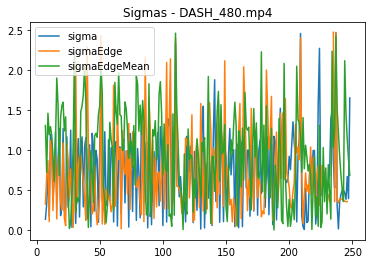

'Anomaly frames: '

Int64Index([], dtype='int64')

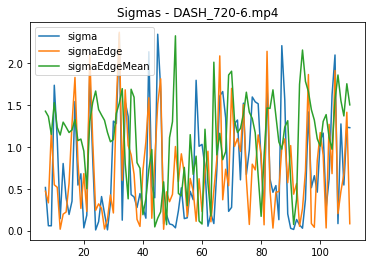

In [ ]:
labels = pd.read_csv(f'{path_prefix}/labels.csv')
labels.rename(columns={'Video Name': 'filename', 'Starting frame #': 'frame_start', 'First failed frame': 'frame_failure'}, inplace=True)
for index, row in labels[labels['frame_start'] > 2].iterrows():
  lossDf = detect(url=f"{path_prefix}/{row['filename']}", initial_layer_frame = row['frame_start'], debug=False)

  lossDf[['sigma', 'sigmaEdge', 'sigmaEdgeMean']].plot()
  plt.title('Sigmas - ' + row['filename'])
  plt.show()
  

In [34]:
# arr1, arr2, arr3 = detect(url='/content/drive/MyDrive/timelapses/multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743.mp4', initial_layer_frame = 121, debug=False)
frame_diff_arr, edge_mean_arr, edge_diff_arr, ssim_arr, scd_arr = detect(url='/content/drive/MyDrive/timelapses/DASH_720-6.mp4', initial_layer_frame = 7, debug=False)
# arr1, arr2, arr3 = detect(url='/content/drive/MyDrive/timelapses/newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220509072520.mp4', initial_layer_frame = 121, debug=False)



'Anomaly frames: '

Int64Index([], dtype='int64')

In [ ]:
# For debugging SCD:

TEMPORAL_SIZE = 3
# Window size for movAvg and movStd filters:
window_size = 8
min_measure = 8

scd_sigma_limit = 4.5
scd_limit = 7.05
scd_limit2 = 9.2

scd_arr = arr3.copy()
expanded_scd_arr = arr3.copy() # Expand scd_arr by dupliacating the 1st row at the front so th 
for i in range(TEMPORAL_SIZE-1):
  # Create a duplicate of A's first row
  first_row_duplicate = np.expand_dims(expanded_scd_arr[0, :], axis=0)

  # Add the duplicate to the front of A
  expanded_scd_arr = np.vstack([first_row_duplicate, expanded_scd_arr])

temporal_window = np.ones(TEMPORAL_SIZE) / TEMPORAL_SIZE

print(scd_arr.shape)
print(expanded_scd_arr.shape)
# calcMeanArr is the moving average of the scd_arr along axis=0 (timeline) with window size TEMPORAL_SIZE (3)
calcMeanArr = np.apply_along_axis(lambda m: np.convolve(m, temporal_window, 'valid'), axis=0, arr=expanded_scd_arr)

# calcDiffFromCalcMeanArr is the diff between the current SCD and the rolling mean of the previous 3 SCD frames
# shift scd_arr 1 position to the left so that: calcDiffFromCalcMeanArr = scd_arr[i] - mean(scd_arr[i-3], scd_arr[i-2], scd_arr[i-1])
calcDiffFromCalcMeanArr = np.roll(scd_arr, -1, axis=0) - calcMeanArr

# SCDNormArr is the array of the 2-norm (square-root of squares) for each element in calcDiffFromCalcMeanArr
# It's the array of currentNorm in the code. Everywhere currentNorm is used as a scalar, we can use SCDNormArr or SCDNormArrDf as an array
SCDNormArr = np.array([LA.norm(x) for x in np.split(calcDiffFromCalcMeanArr, calcDiffFromCalcMeanArr.shape[0], axis=0)])
SCDNormArrDf = pd.DataFrame(SCDNormArr, columns=['SCDNormArr'])
# Cap SCDNormArr at scd_limit (commented out by Nezih T.)
SCDNormArrDf['SCDNormArrCapped'] = SCDNormArrDf['SCDNormArr'].copy(deep=True)
SCDNormArrDf['SCDNormArrCapped'][SCDNormArrDf['SCDNormArr'] > scd_limit] = scd_limit

# SCDNormArrDf['runningMean'] is the equivalent of runningMean
SCDNormArrDf['runningMean'] = SCDNormArrDf['SCDNormArrCapped'].rolling(window=window_size, center=False).mean()

# SCDNormArrDf['runningStd'] is the equivalent of runningStd
SCDNormArrDf['runningStd'] = SCDNormArrDf['SCDNormArrCapped'].rolling(window=window_size, center=False).std()

# When calculating sigma, the previous runningMean and runningStd should be used:
SCDNormArrDf['runningMeanPrev'] = np.roll(SCDNormArrDf.runningMean, 1)
SCDNormArrDf['runningStdPrev'] = np.roll(SCDNormArrDf.runningStd, 1)

# Eliminating posible false SCD due to rolling:
SCDNormArrDf['runningStdPrev'].iloc[0] = float("nan")
SCDNormArrDf['runningMeanPrev'].iloc[0] = float("nan")


# Calculating SCDsigma:
SCDNormArrDf['SCDsigma'] = abs(SCDNormArrDf['SCDNormArr'] - SCDNormArrDf['runningMeanPrev'])/(SCDNormArrDf['runningStdPrev'] + 1e-7)

# Calculating SCD_detected:
SCDNormArrDf['SCD_detected'] = np.where(((SCDNormArrDf['SCDsigma'] > scd_sigma_limit) & (SCDNormArrDf['SCDNormArr'] >= scd_limit)) | (SCDNormArrDf['SCDNormArr'] >= scd_limit2), scd_sigma_limit, 0)


print(f"scd: {scd_arr.shape}")
print(scd_arr[:4,0:4,0])
print(f"xscd: {expanded_scd_arr.shape}")
print(expanded_scd_arr[:4,0:4,0])
print(f"temporalMeans: {calcMeanArr.shape}")
print(calcMeanArr[:4,0:4,0])
print(f"diff from means: {calcDiffFromCalcMeanArr.shape}")
print(calcDiffFromCalcMeanArr[:4,0:4,0])
print(f"scd norm arr: {SCDNormArr.shape}")
print(SCDNormArr[:9])
print(f"scd norm arr df: {SCDNormArrDf['SCDNormArr'].shape}")
print(SCDNormArrDf['SCDNormArr'][:9])
print(f"SCDNormArrDf['runningMean']: {SCDNormArrDf['runningMean'].shape}")
print(SCDNormArrDf['runningMean'][:9])
print(SCDNormArrDf.head(9))
#print(SCDNormArrDf[530:580])



NameError: ignored

In [ ]:
# A comparison of the outputs of for-loop-based (original) SCD code and cv2.resize-based alternative:

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

example_frame = np.random.randint(0,255,(480,640))

block_size_h = 6
block_size_w = 8

calc = np.zeros((block_size_h,block_size_w))

height_indices_list = list(split(np.arange(example_frame.shape[0]),block_size_h))
width_indices_list = list(split(np.arange(example_frame.shape[1]),block_size_w))

for i in range(block_size_h):
  for j in range(block_size_w):
    height_indices = height_indices_list[i]
    width_indices = width_indices_list[j]
    calc[i,j] = np.mean(example_frame[height_indices[0]:height_indices[-1],width_indices[0]:width_indices[-1]])

calcOrig = calc.copy()

calcNew = cv2.resize(example_frame.astype(float), dsize=(block_size_w, block_size_h), interpolation=cv2.INTER_AREA)

print("Original:")
print(calcOrig)

print("New:")

print(calcNew)

# Result: The two methods produce very similar (but not exact) results




Original:
[[127.1152059  128.04021791 127.45633713 126.9488864  126.50360519
  126.54398334 125.90338087 126.89697164]
 [126.82807242 128.83880788 127.58788656 125.54141964 127.25412594
  126.73353629 126.03749399 127.05928537]
 [124.44624259 127.5808364  127.34257331 127.94087486 127.20781926
  125.41884313 125.37285691 127.39384714]
 [124.9155584  127.11712867 127.65646531 128.83880788 127.53420926
  128.78368851 128.13154943 126.56577472]
 [126.38295145 127.5443038  126.43855151 126.92613363 126.90241948
  126.25252363 126.67024515 127.24002564]
 [127.9343054  125.92485179 127.32350585 126.3529883  126.10959782
  127.06409229 128.12914597 128.71623137]]
New:
[[127.17671591 127.90671589 127.51405965 127.04187216 126.57312217
  126.49077842 125.86140344 126.76702842]
 [126.61468467 128.78484087 127.33937215 125.46327845 127.4298409
  126.60124717 125.78624719 126.96452841]
 [124.58609097 127.4514034  127.41280965 127.6592159  127.3042159
  125.54327844 125.28734095 127.24015341]
 [125